In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# **Positional Embedding**

In [2]:
class PositionalEmbedding(nn.Module):
    def __init__(self, width, max_sequence_length):
      super().__init__()
      max_sequence_length = int(max_sequence_length)
      pe = torch.zeros(max_sequence_length, width)

      for pos in range(max_sequence_length):
        for i in range(width):
          if i % 2 == 0:
            pe[pos][i] = np.sin(pos/(10000 ** (i/width))) # getting positional embeddings
          else:
            pe[pos][i] = np.cos(pos/(10000 ** ((i)/width))) # getting positional embeddings
      self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
      x = x + self.pe

      return x

# **ViT Attention Head**

In [ ]:
class AttentionHead(nn.Module):
  def __init__(self, width, head_size):
    super().__init__()
    self.head_size = head_size


    self.query = nn.Linear(width, head_size)
    self.key = nn.Linear(width, head_size)
    self.value = nn.Linear(width, head_size)

  def forward(self, x, mask=None): 
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    attention = Q @ K.transpose(-2,-1) # getting the relationship between the tokens in a sequence

    # scaling the attention
    attention = attention / (self.head_size ** 0.5) # square root from vector dimension

    if mask is not None:
        assert mask.shape == attention.shape, "Mask shape must match attention shape"
        attention = attention.masked_fill(mask == 0, float("-inf")) 

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

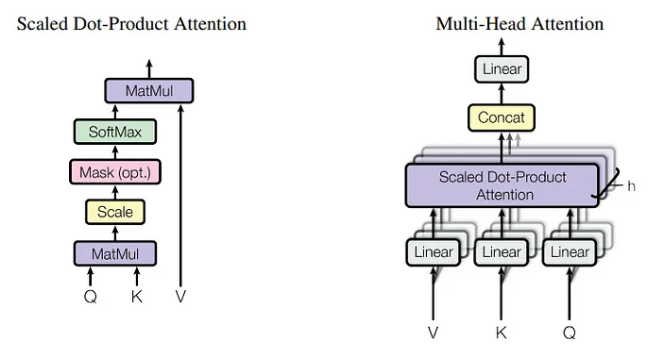

# **ViT Multi-Head Attention**

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, width, n_heads):
    super().__init__()
    assert width % n_heads == 0, "Embedding width must be divisible by the number of heads"
    self.head_size = width // n_heads

    self.W_o = nn.Linear(width, width)

    self.heads = nn.ModuleList([AttentionHead(width, self.head_size) for i in range(n_heads)])
    nn.init.xavier_uniform_(self.W_o.weight)

  def forward(self, x, mask=None):
    out = torch.cat([head(x, mask=mask) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

# **ViT Transformer Encoder**

In [ ]:
# The transformer encoder is made up of two sub-layers: the first sub-layer performs multi-head attention and the second sub-layer contains a multi-layer perceptron.
class TransformerEncoder(nn.Module):
    def __init__(self, width, n_heads, r_mlp=4): # A multiplier for the hidden size of the feed-forward MLP (default is 4)
        super().__init__()

        self.width = width
        self.n_heads = n_heads


        self.ln1 = nn.LayerNorm(width) # ln1 normalizes the input before multi-head attention.

        self.multi_head_att = MultiHeadAttention(width, n_heads) # implements attention across multiple heads

        self.ln2 = nn.LayerNorm(width) # ln2 normalizes the input before the feed-forward MLP


        self.mlp = nn.Sequential(
            nn.Linear(self.width, self.width * r_mlp),
            nn.GELU(), # I use GELU since ReLU is not differentiable at zero
            nn.Linear(self.width * r_mlp, self.width)
        )

        nn.init.xavier_uniform_(self.mlp[0].weight)
        nn.init.xavier_uniform_(self.mlp[2].weight)

    def forward(self, x, mask=None):
      x = x + self.multi_head_att(self.ln1(x), mask=mask)

      x = x + self.mlp(self.ln2(x))

      return x

# **Tokenization**

In [6]:
def tokenizer(text, encode=True, max_seq_length=48):
    if encode:
        text = text[:max_seq_length - 2]
        out = chr(2) + text + chr(3)
        out += chr(0) * (max_seq_length - len(out))
        out_tensor = torch.tensor([ord(c) for c in out], dtype=torch.long)

        mask = torch.zeros(max_seq_length, dtype=torch.long)
        mask[:len(text) + 2] = 1
        return out_tensor, mask
    else:
        out = "".join([chr(x) for x in text[1:-1] if x != 0])
        return out, None

# **CLIP Text-Encoder**

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, width, max_seq_length, n_heads, n_layers, emb_dim):
        super().__init__()

        self.max_sequence_length = max_seq_length

        self.encoder_embedding = nn.Embedding(vocab_size, width)

        self.positional_embedding = PositionalEmbedding(width, self.max_sequence_length)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for i in range(n_layers)])

        # Projecting text encoding from the transformer's output space (width) into a smaller, shared embedding space (emb_dim) for multimodal tasks
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, text, mask=None):
        x = self.encoder_embedding(text)

        x = self.positional_embedding(x)

        for encoder_layer in self.encoder:
            x = encoder_layer(x, mask=mask)

        # Taking features from the EOT Embedding as the final representation of the input sequence. Represents the entire input sequence after processing
        x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]

        # Projection into Joint Multimodal Embedding Space
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True) # Normalizing embedding to have unit norm (L2 normalization)

        return x

# **CLIP Vision Encoder**

In [8]:
class ImageEncoder(nn.Module):
    def __init__(self, width, img_size, patch_size, n_channels, n_layers, n_heads, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert width % n_heads == 0, "width must be divisible by n_heads"

        self.n_patches = (img_size[0] / patch_size[0]) * (img_size[1] / patch_size[1])

        self.max_sequence_length = self.n_patches + 1

        self.linear_project = nn.Conv2d(n_channels, width, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, width))

        self.positional_embedding = PositionalEmbedding(width, self.max_sequence_length)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for i in range(n_layers)])

        # learned proj of image to embed
        self.projection = nn.Parameter(torch.randn(width, emb_dim))


    def forward(self,x):
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)

        x = torch.cat((self.cls_token.expand(x.size()[0], -1, -1),x), dim=1)
        x = self.positional_embedding(x)

        for encoder_layer in self.encoder:
            x = encoder_layer(x)

        x = x[:, 0, :]

        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

# **CLIP**

In [9]:
class CLIP(nn.Module):
    def __init__(self, emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers):
        super().__init__()

        self.image_encoder = ImageEncoder(vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, emb_dim)
        self.text_encoder = TextEncoder(vocab_size, text_width, max_seq_length, text_heads, text_layers, emb_dim)

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.2))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, image, text, mask=None):
        img_emb = self.image_encoder(image)
        txt_emb = self.text_encoder(text, mask=mask)

        scaled_temperature = torch.clamp(torch.exp(self.temperature), min=1e-7, max=1e2)
        logits = (img_emb @ txt_emb.transpose(-2, -1)) * scaled_temperature

        # symmetric Loss
        labels = torch.arange(logits.shape[0], device=image.device)
        loss_i = nn.functional.cross_entropy(logits.transpose(-2, -1), labels)
        loss_t = nn.functional.cross_entropy(logits, labels)

        loss = (loss_i + loss_t) / 2

        return loss

# **Dataset**

In [10]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomCrop, ColorJitter, ToTensor, Normalize

class CIFAR10Dataset(Dataset):
    def __init__(self, train=True, partial=True):
        self.train = train
        self.partial = partial

        full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

        if self.partial:
          fraction = 0.1
          num_train_samples = int(len(full_train_dataset) * fraction)
          random_seed = 42
          torch.manual_seed(random_seed)
          random_indices = torch.randperm(len(full_train_dataset))[:num_train_samples]
          train_subset = Subset(full_train_dataset, random_indices)
          self.dataset = train_subset
        else:
          self.dataset = full_train_dataset


        if self.train:
            self.transform = Compose([
                RandomHorizontalFlip(),
                RandomCrop(32, padding=4),
                ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                ToTensor(),
                Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
            ])
        else:
            self.transform = Compose([
                ToTensor(),
                Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
            ])

        self.captions = {
            0: "An image of a plane",
            1: "An image of a car",
            2: "An image of a bird",
            3: "An image of a cat",
            4: "An image of a deer",
            5: "An image of a dog",
            6: "An image of a frog",
            7: "An image of a horse",
            8: "An image of a ship",
            9: "An image of a truck"
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        img, label = self.dataset[i]
        img = self.transform(img)

        if self.train:
            cap, mask = tokenizer(self.captions[label])
            mask = mask.repeat(len(mask), 1)
            return img, cap, mask
        else:
            return img, label


# **Training Parameters**

In [11]:
emb_dim = 128
vit_width = 32
img_size = (32,32)
patch_size = (4,4)
n_channels = 3
vit_layers = 8
vit_heads = 8
vocab_size = 256
text_width = 48
max_seq_length = 48
text_heads = 8
text_layers = 6
lr = 1e-3
epochs = 70
batch_size = 16

In [12]:
train_dataset = CIFAR10Dataset(train=True, partial=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 35147621.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [13]:
path = '/kaggle/working/clip.pth'

# **Training**

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

best_loss = float("inf")

for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()

    for i, (img, cap, mask) in enumerate(train_loader):
        img, cap, mask = img.to(device), cap.to(device), mask.to(device)
        loss = model(img, cap, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), path)
        print("Model Saved.")

Using device:  cuda (Tesla T4)
Epoch [1/70], Average Loss: 2.289
Model Saved.
Epoch [2/70], Average Loss: 2.045
Model Saved.
Epoch [3/70], Average Loss: 1.943
Model Saved.
Epoch [4/70], Average Loss: 1.875
Model Saved.
Epoch [5/70], Average Loss: 1.822
Model Saved.
Epoch [6/70], Average Loss: 1.772
Model Saved.
Epoch [7/70], Average Loss: 1.732
Model Saved.
Epoch [8/70], Average Loss: 1.697
Model Saved.
Epoch [9/70], Average Loss: 1.666
Model Saved.
Epoch [10/70], Average Loss: 1.642
Model Saved.
Epoch [11/70], Average Loss: 1.613
Model Saved.
Epoch [12/70], Average Loss: 1.588
Model Saved.
Epoch [13/70], Average Loss: 1.571
Model Saved.
Epoch [14/70], Average Loss: 1.553
Model Saved.
Epoch [15/70], Average Loss: 1.533
Model Saved.
Epoch [16/70], Average Loss: 1.520
Model Saved.
Epoch [17/70], Average Loss: 1.503
Model Saved.
Epoch [18/70], Average Loss: 1.490
Model Saved.
Epoch [19/70], Average Loss: 1.476
Model Saved.
Epoch [20/70], Average Loss: 1.469
Model Saved.
Epoch [21/70], Ave

# **CLIP Classification**

/tmp/ipykernel_23/2011028906.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Files already downloaded and verified


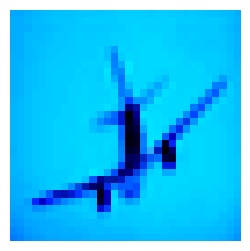


Top predictions:

           plane: 100.00%
            bird: 0.00%
           truck: 0.00%
             dog: 0.00%
            deer: 0.00%


In [ ]:
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load(path, map_location=device))

full_test_dataset = CIFAR10Dataset(train=False)
fraction = 0.48
num_train_samples = int(len(full_test_dataset) * fraction)
random_seed = 42
torch.manual_seed(random_seed)
random_indices = torch.randperm(len(full_test_dataset))[:num_train_samples]
test_subset = Subset(full_test_dataset, random_indices)


test_loader = DataLoader(test_subset, batch_size=48, shuffle=False)


class_names =["plane",
                        "car",
                        "bird",
                        "cat",
                        "deer",
                        "dog",
                        "frog",
                        "horse",
                        "ship",
                        "truck"]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 1000

img = test_subset[idx][0][None,:]
plt.figure(figsize=(3, 3))
plt.imshow(img[0].permute(1, 2, 0))
plt.axis('off')
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.image_encoder(img)
  text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")